In [ ]:
!pip install tkan

In [ ]:
!pip install pykan

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.1/78.1 kB 2.1 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler



SEQ_LEN = 8
SEED = 42


df = pd.read_csv("ibtracscyclicfinal.csv")


df = pd.get_dummies(df, columns=["basin"], drop_first=False)
df = df.sort_values(["storm_id", "lead"])
df = df.drop_duplicates(subset=["storm_id", "lead"]).reset_index(drop=True)

storms = (df[["storm_id", "istc"]]
          .drop_duplicates()
          .reset_index(drop=True))

num_cols = ["wind","slp","pr","rh","rv","geop"]
frame_cols = (
    num_cols +
    ["sin_hour","cos_hour","sin_doy","cos_doy",
     "sin_lon","cos_lon","lat_norm",
     "lead"] +
    [c for c in df.columns if c.startswith("basin_")]
)

df.loc[:, frame_cols] = df[frame_cols].astype(np.float32)

def build_xy_sequential(frame_df):
    xs, ys = [], []
    dbase = len(frame_cols)
    for storm_id_val, g in frame_df.groupby("storm_id"):
        g = g.sort_values("lead")


        arr = g[frame_cols].tail(SEQ_LEN).to_numpy(np.float32)

        if arr.shape[0] == SEQ_LEN:
            arr_processed = arr
        elif arr.shape[0] < SEQ_LEN:
            padding_rows = SEQ_LEN - arr.shape[0]
            padding = np.zeros((padding_rows, dbase), dtype=np.float32)
            arr_processed = np.concatenate((padding, arr), axis=0)
        else:
            arr_processed = arr[-SEQ_LEN:, :]

        xs.append(arr_processed)
      '
        ys.append(g["istc"].iloc[-1])

    return np.array(xs, dtype=np.float32), np.array(ys, dtype=np.float32)


train_ids, temp_ids, y_train_g, y_temp_g = train_test_split(
        storms["storm_id"], storms["istc"],
        test_size=0.30, stratify=storms["istc"],
        random_state=SEED)

val_ids,  test_ids, y_val_g, y_test_g = train_test_split(
        temp_ids, y_temp_g,
        test_size=0.50, stratify=y_temp_g,
        random_state=SEED)

train_df = df[df["storm_id"].isin(train_ids)].reset_index(drop=True)
val_df   = df[df["storm_id"].isin(val_ids)].reset_index(drop=True)
test_df  = df[df["storm_id"].isin(test_ids)].reset_index(drop=True)

X_train, y_train = build_xy_sequential(train_df)
X_val,   y_val   = build_xy_sequential(val_df)
X_test,  y_test  = build_xy_sequential(test_df)

print(f"Shape of X_train before scaling: {X_train.shape}")
print(f"Shape of y_train: {y_train.shape}")


num_samples_train, seq_len_train, num_features_train = X_train.shape
num_samples_val, _, _ = X_val.shape
num_samples_test, _, _ = X_test.shape

X_train_reshaped = X_train.reshape(-1, num_features_train)
X_val_reshaped = X_val.reshape(-1, num_features_train)
X_test_reshaped = X_test.reshape(-1, num_features_train)

scaler = StandardScaler().fit(X_train_reshaped)

X_train_scaled_reshaped = scaler.transform(X_train_reshaped)
X_val_scaled_reshaped = scaler.transform(X_val_reshaped)
X_test_scaled_reshaped = scaler.transform(X_test_reshaped)

X_train = X_train_scaled_reshaped.reshape(num_samples_train, seq_len_train, num_features_train)
X_val = X_val_scaled_reshaped.reshape(num_samples_val, seq_len_train, num_features_train)
X_test = X_test_scaled_reshaped.reshape(num_samples_test, seq_len_train, num_features_train)



print(f"Shape of X_train after scaling: {X_train.shape}")
print(f"Shape of X_val after scaling: {X_val.shape}")
print(f"Shape of X_test after scaling: {X_test.shape}")

<ipython-input-2-d0427b18e59b>:39: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0. 0. 0. ... 0. 0. 0.]' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  df.loc[:, frame_cols] = df[frame_cols].astype(np.float32)
<ipython-input-2-d0427b18e59b>:39: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0. 0. 0. ... 0. 0. 0.]' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  df.loc[:, frame_cols] = df[frame_cols].astype(np.float32)
<ipython-input-2-d0427b18e59b>:39: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[1. 1. 1. ... 0. 0. 0.]' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  df.loc[:, frame_cols] = df[frame_cols].astype(np.float32)
<ipython-input-2-d0427b18e59

Shape of X_train before scaling: (11193, 8, 21)
Shape of y_train: (11193,)
Shape of X_train after scaling: (11193, 8, 21)
Shape of X_val after scaling: (2399, 8, 21)
Shape of X_test after scaling: (2399, 8, 21)


In [ ]:
y_train = y_train.reshape(-1, 1)
y_val = y_val.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

print(f"Shape of y_train after reshaping for F1Score: {y_train.shape}")
print(f"Shape of y_val after reshaping for F1Score: {y_val.shape}")


Shape of y_train after reshaping for F1Score: (11193, 1)
Shape of y_val after reshaping for F1Score: (2399, 1)


In [ ]:
print(f"NaNs in X_train: {np.isnan(X_train).any()}")
print(f"Infs in X_train: {np.isinf(X_train).any()}")
print(f"NaNs in y_train: {np.isnan(y_train).any()}")
print(f"Infs in y_train: {np.isinf(y_train).any()}")

NaNs in X_train: False
Infs in X_train: False
NaNs in y_train: False
Infs in y_train: False


In [ ]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
FINAL_RATIO = 0.25


In [ ]:
print(f"X_train shape before SMOTE/RUS (3D, scaled): {X_train.shape}")
print(f"y_train shape before SMOTE/RUS (1D): {y_train.shape}")

X_train_flat_for_resampling = X_train.reshape(X_train.shape[0], -1)
print(f"X_train shape for SMOTE (flattened 2D): {X_train_flat_for_resampling.shape}")


# --- SMOTE ---
minority_samples_count = np.sum(y_train == 1) # y_train is 1D here
k_neighbors_smote = max(1, min(5, minority_samples_count - 1 if minority_samples_count > 1 else 1))
print(f"Using k_neighbors={k_neighbors_smote} for SMOTE.")

SMOTE_RATIO = max(FINAL_RATIO, 0.01)
smote = SMOTE(sampling_strategy=SMOTE_RATIO, k_neighbors=k_neighbors_smote, random_state=SEED)
X_sm_flat, y_sm_1d = smote.fit_resample(X_train_flat_for_resampling, y_train) # y_train is 1D
print(f"Shape after SMOTE: X_sm_flat: {X_sm_flat.shape}, y_sm_1d: {y_sm_1d.shape}")
print(f"y_sm_1d distribution after SMOTE: {pd.Series(y_sm_1d).value_counts(normalize=True)}")

m = (y_sm_1d == 1).sum()
M_sm = (y_sm_1d == 0).sum()
cur_rat = m / M_sm if M_sm > 0 else float('inf')

if FINAL_RATIO < cur_rat and M_sm > 0 :
    print(f"Current ratio after SMOTE ({cur_rat:.2f}) > FINAL_RATIO ({FINAL_RATIO:.2f}). Applying RUS.")
    M_target = int(m / FINAL_RATIO)
    if M_target >= M_sm :
        print("Target majority for RUS is >= current majority after SMOTE. Skipping RUS.")
        X_bal_flat, y_bal_1d = X_sm_flat, y_sm_1d
    else:
        rus = RandomUnderSampler(sampling_strategy={0: M_target}, random_state=SEED)
        X_bal_flat, y_bal_1d = rus.fit_resample(X_sm_flat, y_sm_1d)
else:
    print(f"Current ratio after SMOTE ({cur_rat:.2f}) <= FINAL_RATIO ({FINAL_RATIO:.2f}) or no majority samples. Skipping RUS.")
    X_bal_flat, y_bal_1d = X_sm_flat, y_sm_1d

print(f"Class distribution after Balancing: Positive: {(y_bal_1d == 1).sum()}, Negative: {(y_bal_1d == 0).sum()}")
if (y_bal_1d == 0).sum() > 0:
    print(f"Ratio after Balancing: {(y_bal_1d == 1).sum() / (y_bal_1d == 0).sum():.3f}")


X_bal_reshaped_3d = X_bal_flat.reshape(-1, seq_len_train, num_features_train)

print(f"Final X_train (X_bal_reshaped_3d) shape for model: {X_bal_reshaped_3d.shape}")
print(f"Final y_train (y_bal_1d) shape for model (1D): {y_bal_1d.shape}")

X_train shape before SMOTE/RUS (3D, scaled): (11193, 8, 21)
y_train shape before SMOTE/RUS (1D): (11193, 1)
X_train shape for SMOTE (flattened 2D): (11193, 168)
Using k_neighbors=5 for SMOTE.
Shape after SMOTE: X_sm_flat: (13856, 168), y_sm_1d: (13856,)
y_sm_1d distribution after SMOTE: 0.0    0.800014
1.0    0.199986
Name: proportion, dtype: float64
Current ratio after SMOTE (0.25) <= FINAL_RATIO (0.25) or no majority samples. Skipping RUS.
Class distribution after Balancing: Positive: 2771, Negative: 11085
Ratio after Balancing: 0.250
Final X_train (X_bal_reshaped_3d) shape for model: (13856, 8, 21)
Final y_train (y_bal_1d) shape for model (1D): (13856,)


In [ ]:
if y_bal_1d.ndim == 1:
    y_bal_2d_for_fit = y_bal_1d.reshape(-1, 1)
else:
    y_bal_2d_for_fit = y_bal_1d

if y_val.ndim == 1:
    y_val_2d_for_fit = y_val.reshape(-1, 1)
else:
    y_val_2d_for_fit = y_val )

print(f"Shape of y_bal_2d_for_fit for F1Score and model.fit: {y_bal_2d_for_fit.shape}")
print(f"Shape of y_val_2d_for_fit for F1Score and model.fit: {y_val_2d_for_fit.shape}")

Shape of y_bal_2d_for_fit for F1Score and model.fit: (13856, 1)
Shape of y_val_2d_for_fit for F1Score and model.fit: (2399, 1)


In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tkan import TKAN
from tensorflow import keras
from tensorflow.keras.layers import InputLayer, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.utils import class_weight
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
INPUT_SHAPE = (8, 21)
NUM_CLASSES = 1
EPOCHS = 100
BATCH_SIZE = 128
SEED = 42

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ tkan_1 (TKAN)                   │ (None, 8, 100)         │        46,318 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ tkan_2 (TKAN)                   │ (None, 8, 100)         │       334,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ tkan_3 (TKAN)                   │ (None, 8, 100)         │       261,900 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ tkan_4 (TKAN)                   │ (None, 100)            │       364,900 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,007,519 (3.84 MB)

 Trainable params: 1,001,762 (3.82 MB)

 Non-trainable params: 5,757 (22.49 KB)

In [ ]:
def create_smaller_tkan_model(input_shape, num_classes):
    model = keras.Sequential([
        InputLayer(input_shape=input_shape),
        TKAN(21,
             sub_kan_configs=[{'spline_order': 3, 'grid_size': 8}],
             return_sequences=True,
             use_bias=True,
             name="tkan_small_1"),
        TKAN(21,
             sub_kan_configs=['relu', 'relu'],
             return_sequences=False,
             use_bias=True,
             name="tkan_small_2"),

        Dense(num_classes, activation='sigmoid', name="output_layer")
    ])
    return model
smaller_model = create_smaller_tkan_model(INPUT_SHAPE, NUM_CLASSES)
smaller_model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ tkan_small_1 (TKAN)             │ (None, 8, 21)          │         9,765 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ tkan_small_2 (TKAN)             │ (None, 21)             │         6,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 1)              │            22 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,171 (63.17 KB)

 Trainable params: 15,856 (61.94 KB)

 Non-trainable params: 315 (1.23 KB)

In [ ]:
optimizer = keras.optimizers.Adam(learning_rate=1e-3) # Example learning rate
f1_metric_instance = keras.metrics.F1Score(threshold=0.5, name='f1_score') # NO SPACE HERE

smaller_model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy',
                       keras.metrics.Precision(name='precision'),
                       keras.metrics.Recall(name='recall'),
                       keras.metrics.AUC(name='auc'),
                       f1_metric_instance,
                       keras.metrics.AUC(name='pr_auc', curve='PR')])


In [ ]:
print("\nCalculating class weights (on resampled training data y_bal_1d)...")
if np.any(np.isnan(y_bal_1d)) or np.any(np.isinf(y_bal_1d)):
    print("ERROR: NaNs or Infs found in y_bal_1d before class weight calculation!")
    class_weights_dict = None
else:
    if len(np.unique(y_bal_1d)) < 2 :
        print(f"WARNING: Only one class present in resampled y_bal_1d: {np.unique(y_bal_1d)}. Class weights set to None.")
        class_weights_dict = None
    else:
        class_weights_array_calc = class_weight.compute_class_weight(
            class_weight='balanced',
            classes=np.unique(y_bal_1d),
            y=y_bal_1d
        )
        class_weights_dict = dict(enumerate(class_weights_array_calc))
    print(f"Calculated Class Weights: {class_weights_dict}")


early_stopping = EarlyStopping(monitor='val_f1_score',
                               patience=20,
                               verbose=1,
                               mode='max',
                               restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(monitor='val_f1_score',
                              factor=0.2,
                              patience=20,
                              min_lr=1e-7,
                              verbose=1,
                              mode='max')


Calculating class weights (on resampled training data y_bal_1d)...
Calculated Class Weights: {0: np.float64(0.6249887235002255), 1: np.float64(2.5001804402742693)}


In [ ]:
print("\nStarting model training...")
history = smaller_model.fit(X_bal_reshaped_3d, y_bal_2d_for_fit,
                    epochs=EPOCHS,
                    batch_size=BATCH_SIZE,
                    validation_data=(X_val, y_val),
                    class_weight=class_weights_dict,
                    callbacks=[early_stopping, reduce_lr],
                    verbose=1)



Starting model training...
Epoch 1/100
109/109 ━━━━━━━━━━━━━━━━━━━━ 32s 144ms/step - accuracy: 0.7092 - auc: 0.7177 - f1_score: 0.4151 - loss: 0.6378 - pr_auc: 0.4670 - precision: 0.3413 - recall: 0.5640 - val_accuracy: 0.8608 - val_auc: 0.8880 - val_f1_score: 0.1117 - val_loss: 0.3355 - val_pr_auc: 0.2736 - val_precision: 0.0597 - val_recall: 0.8750 - learning_rate: 0.0010
Epoch 2/100
109/109 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9090 - auc: 0.9676 - f1_score: 0.8092 - loss: 0.2226 - pr_auc: 0.8688 - precision: 0.7033 - recall: 0.9529 - val_accuracy: 0.9187 - val_auc: 0.9138 - val_f1_score: 0.1558 - val_loss: 0.2040 - val_pr_auc: 0.3023 - val_precision: 0.0870 - val_recall: 0.7500 - learning_rate: 0.0010
Epoch 3/100
109/109 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9404 - auc: 0.9824 - f1_score: 0.8688 - loss: 0.1511 - pr_auc: 0.9150 - precision: 0.7830 - recall: 0.9758 - val_accuracy: 0.9596 - val_auc: 0.9139 - val_f1_score: 0.2240 - val_loss: 0.1114 - val_pr_auc: 0.

In [ ]:
print("\nEvaluating on Validation Set...")
results = smaller_model.evaluate(X_val, y_val, verbose=0)
val_loss = results[0]
val_accuracy = results[1]
val_precision = results[2]
val_recall = results[3]
val_auc = results[4]
val_f1_score = results[5]
val_pr_auc = results[6]


print(f"Validation Loss: {val_loss:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4f}")
print(f"Validation Precision: {val_precision:.4f}")
print(f"Validation Recall: {val_recall:.4f}")
print(f"Validation AUC: {val_auc:.4f}")
print(f"Validation F1 Score: {val_f1_score:.4f}")
print(f"Validation PR-AUC: {val_pr_auc:.4f}")



Evaluating on Validation Set...
Validation Loss: 0.0574
Validation Accuracy: 0.9850
Validation Precision: 0.3421
Validation Recall: 0.5417
Validation AUC: 0.8441
Validation F1 Score: 0.4194
Validation PR-AUC: 0.3918



--- Starting SHAP Analysis for the trained Keras model ---
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 737ms/step
Calculating SHAP values on validation instances using KernelExplainer (this may take a moment)...


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
7400/7400 ━━━━━━━━━━━━━━━━━━━━ 17s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
7400/7400 ━━━━━━━━━━━━━━━━━━━━ 17s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
7400/7400 ━━━━━━━━━━━━━━━━━━━━ 19s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
7400/7400 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
7400/7400 ━━━━━━━━━━━━━━━━━━━━ 17s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
7400/7400 ━━━━━━━━━━━━━━━━━━━━ 17s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
7400/7400 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
7400/7400 ━━━━━━━━━━━━━━━━━━━━ 17s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
7400/7400 ━━━━━━━━━━━━━━━━━━━━ 17s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
7400/7400 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
7400/7400 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
7400/7400 ━━━━━━━━━━━━━━━━━━━━ 17s 2ms/step
1/1 ━━━━━━━━━━━━━━

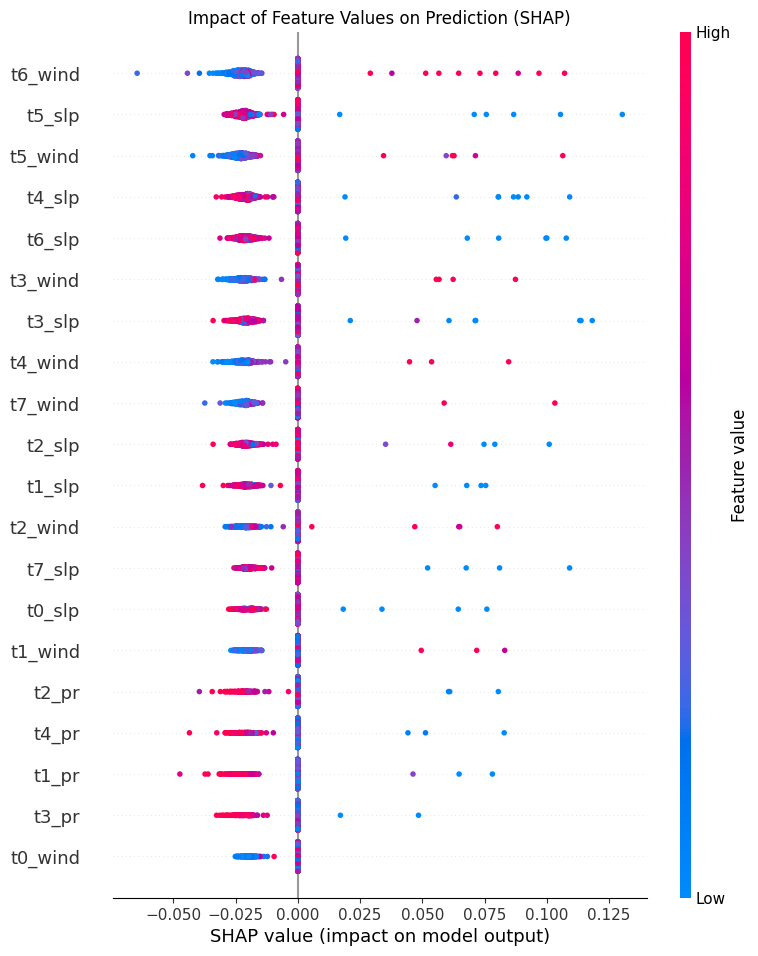


Generating SHAP Global Feature Importance Plot (Bar)...


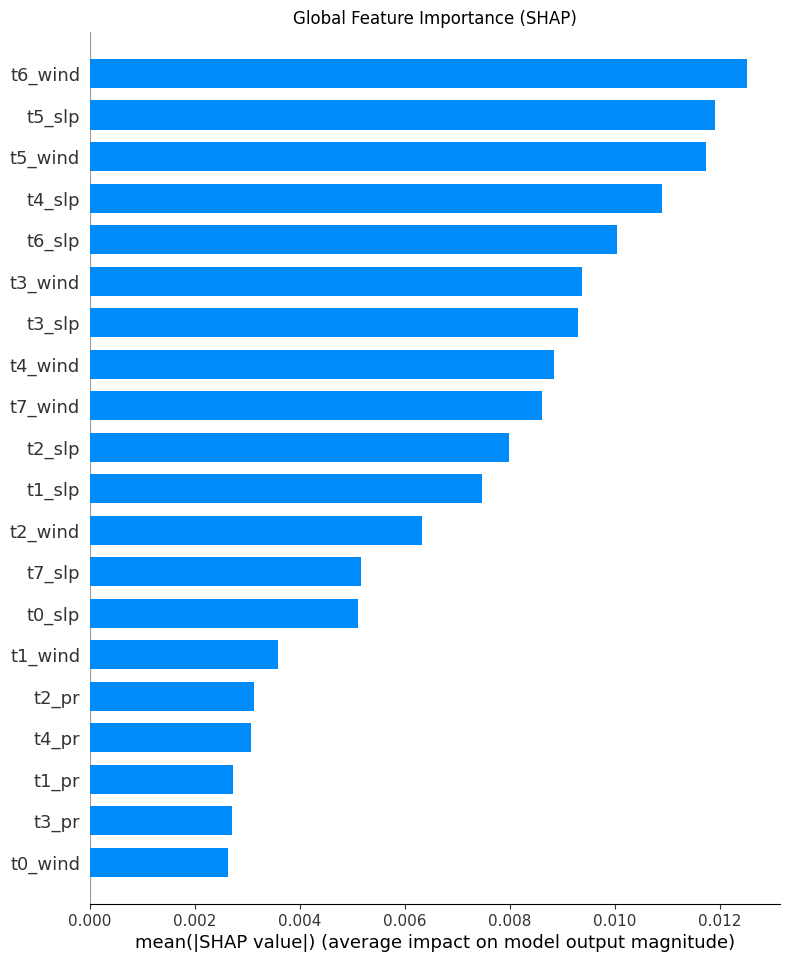


Generating SHAP Force Plot for the first validation instance...


<Figure size 640x480 with 0 Axes>

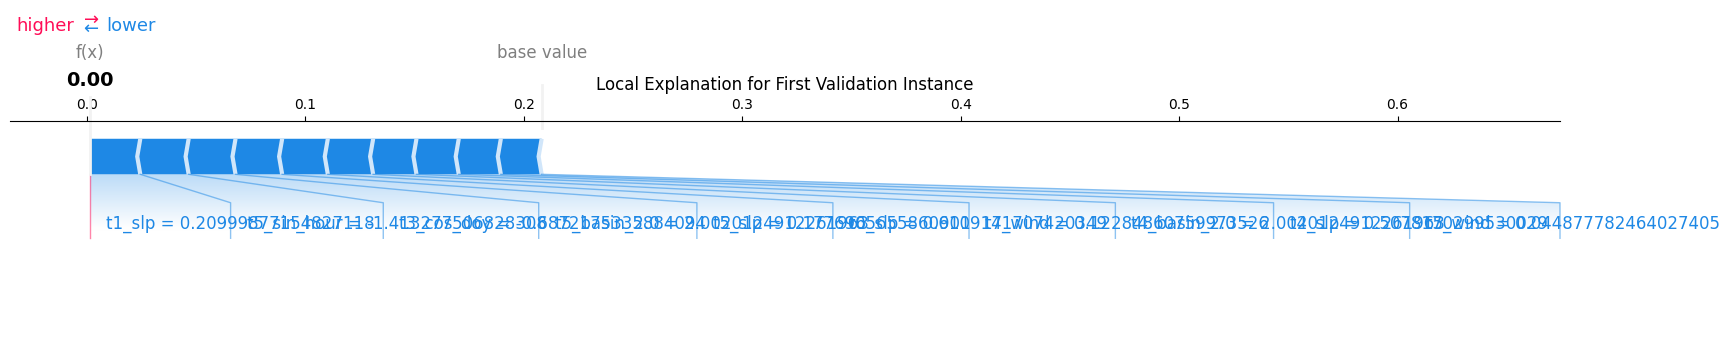

--- SHAP Analysis Complete ---



In [ ]:
import shap
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt



print("\n--- Starting SHAP Analysis for the trained Keras model ---")


X_train_final_flat = X_bal_reshaped_3d.reshape(X_bal_reshaped_3d.shape[0], -1)
X_val_flat = X_val.reshape(X_val.shape[0], -1)


background_data_np = X_train_final_flat[np.random.choice(X_train_final_flat.shape[0], 100, replace=False)]

instances_to_explain_np = X_val_flat[:1000]

s.
def model_predict_for_shap(numpy_array):

    num_samples = numpy_array.shape[0]
    reshaped_array = numpy_array.reshape(num_samples, SEQ_LEN, num_features_train)

    prediction = smaller_model.predict(reshaped_array)
.
    return prediction.flatten()


explainer = shap.KernelExplainer(model_predict_for_shap, background_data_np)



print("Calculating SHAP values on validation instances using KernelExplainer (this may take a moment)...")
shap_values = explainer.shap_values(instances_to_explain_np, nsamples="auto")
print("SHAP values calculated.")


=feature_names = [f"t{i//len(frame_cols)}_{frame_cols[i%len(frame_cols)]}" for i in range(X_train_final_flat.shape[1])]
instances_df = pd.DataFrame(instances_to_explain_np, columns=feature_names)


if isinstance(shap_values, list) and len(shap_values) == 1:
    shap_values = shap_values[0]

=
print("\nGenerating SHAP Feature Impact Plot (Beeswarm)...")
plt.figure()
shap.summary_plot(shap_values, instances_df, show=False, plot_type="dot")
plt.title("Impact of Feature Values on Prediction (SHAP)")
plt.show()

print("\nGenerating SHAP Global Feature Importance Plot (Bar)...")
plt.figure()
shap.summary_plot(shap_values, instances_df, plot_type="bar", show=False)
plt.title("Global Feature Importance (SHAP)")
plt.show()

print(f"\nGenerating SHAP Force Plot for the first validation instance...")
plt.figure()

shap.force_plot(
    explainer.expected_value,
    shap_values[0,:],
    instances_df.iloc[0,:],
    matplotlib=True,
    show=False
)
plt.title("Local Explanation for First Validation Instance")
plt.show()

print(f"--- SHAP Analysis Complete ---\n")


In [ ]:
!pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 9.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=06e7cff79966dd567004830f4a292297335534e86217002f603c276c6cb62f70
  Stored in directory: /root/.cache/pip/wheels/85/fa/a3/9c2d44c9f3cd77cf4e533b58900b2bf4487f2a17e8ec212a3d
Successfully built lime


In [ ]:
import lime
import lime.lime_tabular
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


print("\n--- Starting LIME Analysis for Specific Cases ---")


X_val_flat = X_val.reshape(X_val.shape[0], -1)
y_val_pred_proba = smaller_model.predict(X_val).flatten()
y_val_true = y_val.flatten()

PREDICTION_THRESHOLD = 0.5
y_val_pred_class = (y_val_pred_proba >= PREDICTION_THRESHOLD).astype(int)

false_neg_idx = np.where((y_val_true == 1) & (y_val_pred_class == 0))[0]
false_pos_idx = np.where((y_val_true == 0) & (y_val_pred_class == 1))[0]
true_neg_idx  = np.where((y_val_true == 0) & (y_val_pred_class == 0))[0]
true_pos_idx  = np.where((y_val_true == 1) & (y_val_pred_class == 1))[0]

fn_idx = false_neg_idx[0] if len(false_neg_idx) > 0 else None
fp_idx = false_pos_idx[0] if len(false_pos_idx) > 0 else None
tn_idx = true_neg_idx[0] if len(true_neg_idx) > 0 else None
tp_idx = true_pos_idx[0] if len(true_pos_idx) > 0 else None

print(f"Found instance for False Negative: {'Yes' if fn_idx is not None else 'No'}")
print(f"Found instance for False Positive: {'Yes' if fp_idx is not None else 'No'}")
print(f"Found instance for True Negative:  {'Yes' if tn_idx is not None else 'No'}")
print(f"Found instance for True Positive:  {'Yes' if tp_idx is not None else 'No'}")


def lime_predict_fn(numpy_array_2d):
    num_samples = numpy_array_2d.shape[0]

    reshaped_array_3d = numpy_array_2d.reshape(num_samples, SEQ_LEN, num_features_train)

    probabilities = smaller_model.predict(reshaped_array_3d)

    return np.hstack((1 - probabilities, probabilities))

feature_names = [f"t{i//len(frame_cols)}_{frame_cols[i%len(frame_cols)]}" for i in range(X_train_final_flat.shape[1])]


explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=X_train_final_flat,
    feature_names=feature_names,
    class_names=['Not Tropical Cyclone', 'Tropical Cyclone'],
    mode='classification'
)

def explain_instance(title, instance_idx):
    if instance_idx is None:
        print(f"\n--- {title}: No instance found to explain. ---")
        return

    print(f"\n--- Explaining: {title} (Validation Set Index: {instance_idx}) ---")

    instance_to_explain = X_val_flat[instance_idx]

    pred_probs = lime_predict_fn(instance_to_explain.reshape(1, -1))[0]
    true_label_text = 'Tropical Cyclone' if y_val_true[instance_idx] == 1 else 'Not Tropical Cyclone'

    print(f"True Label: {true_label_text}")
    print(f"Model Prediction Probs -> Not TC: {pred_probs[0]:.4f}, Is TC: {pred_probs[1]:.4f}")

    explanation = explainer.explain_instance(
        instance_to_explain,
        lime_predict_fn,
        num_features=15
    )


    explanation.show_in_notebook(show_table=True, show_all=False)



explain_instance("True Positive", tp_idx)
explain_instance("True Negative", tn_idx)
explain_instance("False Positive", fp_idx)
explain_instance("False Negative", fn_idx)

print("\n--- LIME Analysis Complete ---")



--- Starting LIME Analysis for Specific Cases ---
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step
Found instance for False Negative: Yes
Found instance for False Positive: Yes
Found instance for True Negative:  Yes
Found instance for True Positive:  Yes

--- Explaining: True Positive (Validation Set Index: 55) ---
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
True Label: Tropical Cyclone
Model Prediction Probs -> Not TC: 0.0017, Is TC: 0.9983
157/157 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step



--- Explaining: True Negative (Validation Set Index: 0) ---
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
True Label: Not Tropical Cyclone
Model Prediction Probs -> Not TC: 0.9996, Is TC: 0.0004
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step



--- Explaining: False Positive (Validation Set Index: 46) ---
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
True Label: Not Tropical Cyclone
Model Prediction Probs -> Not TC: 0.0209, Is TC: 0.9791
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step



--- Explaining: False Negative (Validation Set Index: 52) ---
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
True Label: Tropical Cyclone
Model Prediction Probs -> Not TC: 0.7484, Is TC: 0.2516
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step



--- LIME Analysis Complete ---



--- Starting LIME Analysis for Specific Cases ---
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Found instance for False Negative: Yes
Found instance for False Positive: Yes
Found instance for True Negative:  Yes
Found instance for True Positive:  Yes

--- Explaining: True Positive (Validation Set Index: 55) ---
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
True Label: Tropical Cyclone
Model Prediction Probs -> Not TC: 0.0017, Is TC: 0.9983
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


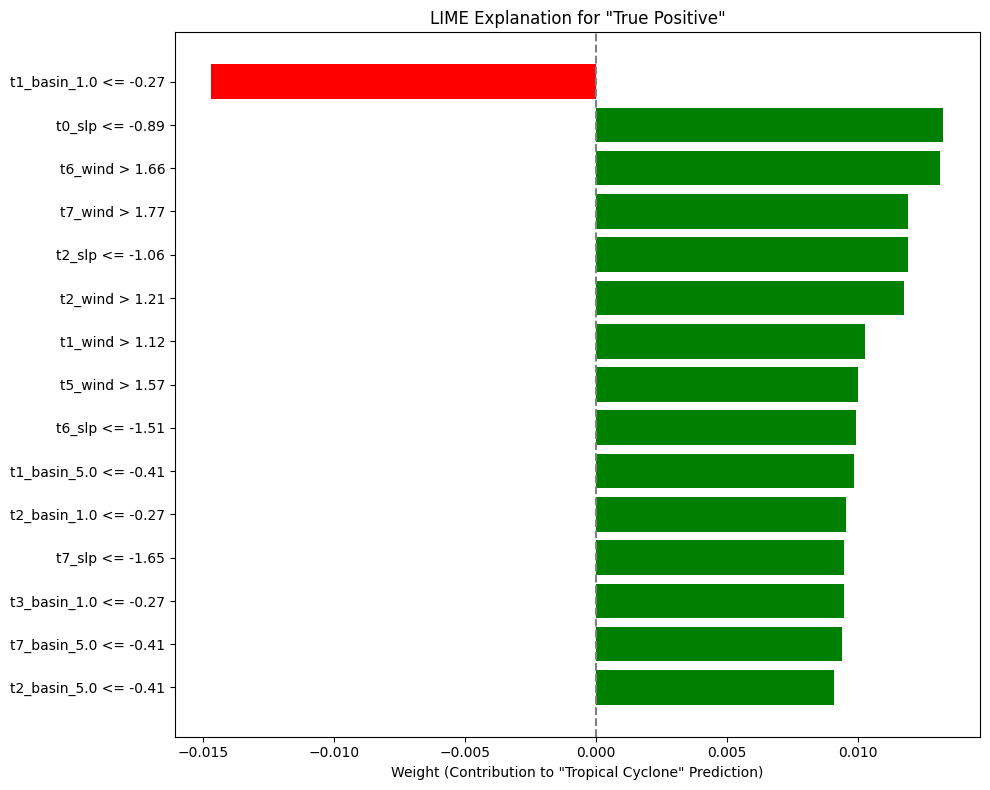


--- Explaining: True Negative (Validation Set Index: 0) ---
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
True Label: Not Tropical Cyclone
Model Prediction Probs -> Not TC: 0.9996, Is TC: 0.0004
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


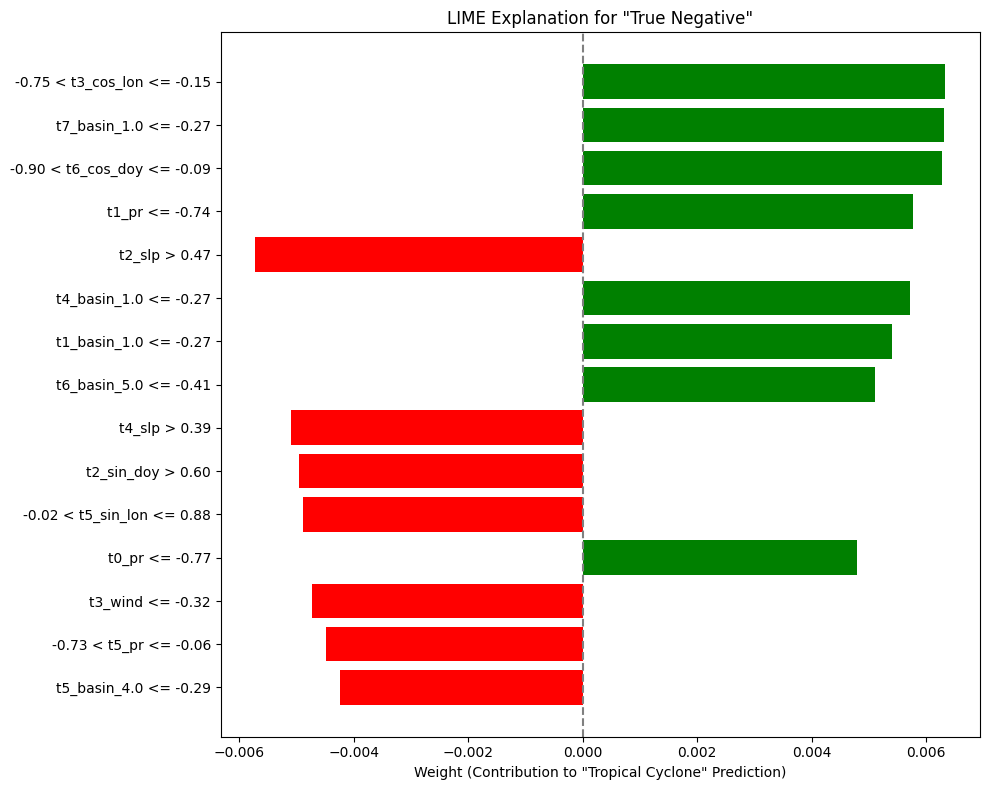


--- Explaining: False Positive (Validation Set Index: 46) ---
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
True Label: Not Tropical Cyclone
Model Prediction Probs -> Not TC: 0.0209, Is TC: 0.9791
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


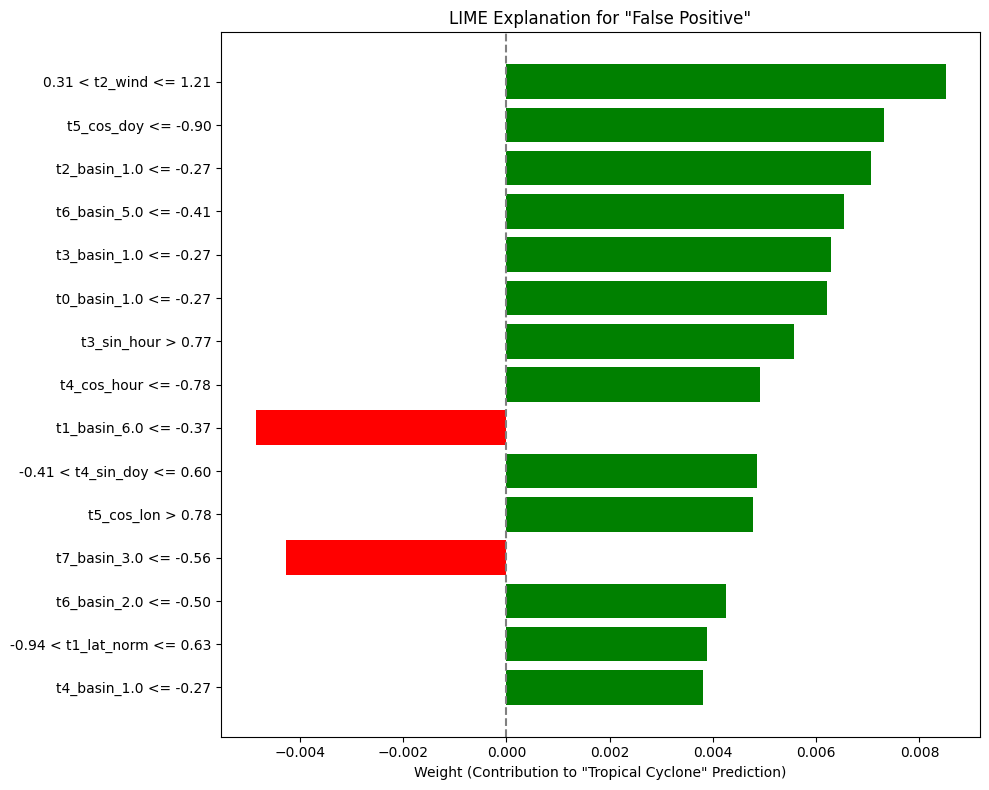


--- Explaining: False Negative (Validation Set Index: 52) ---
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
True Label: Tropical Cyclone
Model Prediction Probs -> Not TC: 0.7484, Is TC: 0.2516
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


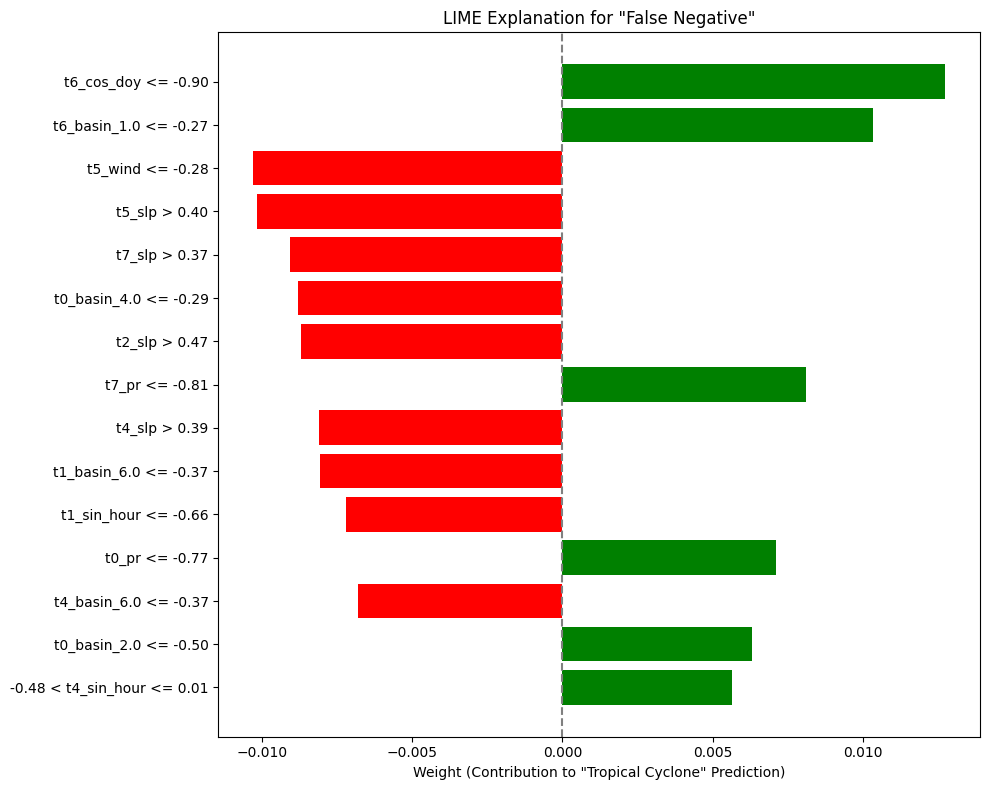


--- LIME Analysis Complete ---
